In [1]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.models import ExactGPModel
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [2]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.3
COORDS = (54.95074, -1.5278)

In [3]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [5]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

In [73]:
from mpl_toolkits.basemap import Basemap

def plot_grid(df, COORDS, RADIUS):
    """
    Plot the grid of the UK with the PV systems

    Args:
        df (pd.DataFrame): dataframe containing the PV systems
        COORDS (tuple): coordinates of the center of the circle
        RADIUS (float): radius of the circle
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create Basemap instance
    map_uk = Basemap(llcrnrlon=-7, llcrnrlat=49, urcrnrlon=2, urcrnrlat=60, resolution='l', ax=ax)

    # Draw coastlines and country boundaries
    map_uk.drawcoastlines()
    map_uk.drawcountries()

    # add some nice background colours
    map_uk.fillcontinents(color='forestgreen', lake_color='lightblue', alpha=0.5)

    # Plot PV systems
    x, y = map_uk(df['longitude_noisy'].values, df['latitude_noisy'].values)
    map_uk.scatter(x, y, alpha=0.4, color='b', label='PV systems')

    # Draw a circle representing the desired area
    lon, lat = map_uk(COORDS[1], COORDS[0])
    circle = plt.Circle((lon, lat), RADIUS, color='r', fill=True, alpha=0.3, label='Selected Area')
    ax.add_patch(circle)


    ax.set_xticks(np.arange(-7, 3,))
    ax.set_yticks(np.arange(49, 61))

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('PV systems in the UK')
    ax.legend()

    plt.show()

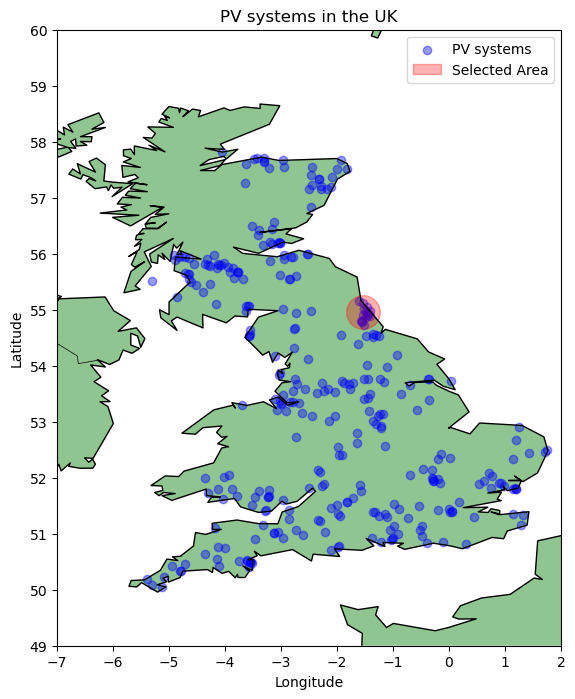

In [74]:
# from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [58]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=65,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [59]:
time, y = loader.get_time_series()

In [64]:
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)

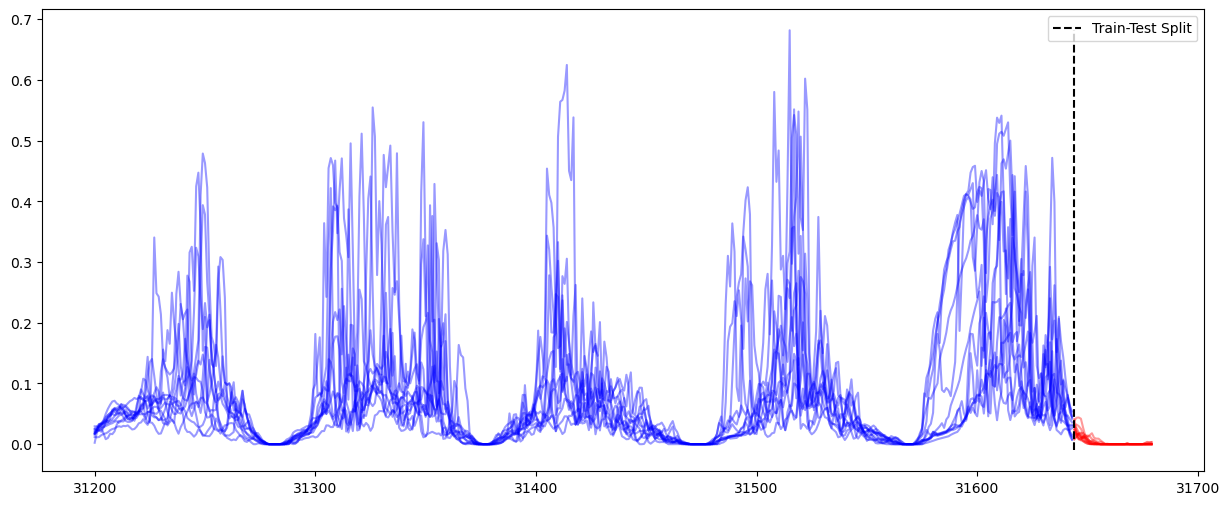

In [65]:
# set figure size
plt.figure(figsize=(15, 6))

plt.plot(time_train, y_train, color='b', alpha=0.4)
plt.plot(time_test, y_test, color='r', alpha=0.4)
plt.vlines(x= time_train[0] + len(time_train), ymin=-0.01, ymax=max(y_train.max(), y_test.max()), label='Train-Test Split', color='black', linestyle='--')
plt.legend()

plt.show();

# Stochastic Variational Inference for Gaussian Processes

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

class StochasticVariationalInferenceGP(ApproximateGP):
    """ 
    Stochastic Variational Inference GP model for regression

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self, inducing_points, variational_dist, mean_module, covar_module):
        variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, 
                                                   inducing_points=inducing_points, 
                                                   variational_distribution=variational_dist, 
                                                   learn_inducing_locations=True)
        super(StochasticVariationalInferenceGP, self).__init__(variational_strategy)
        self.mean_module = mean_module
        self.covar_module = covar_module
    

# Baselines

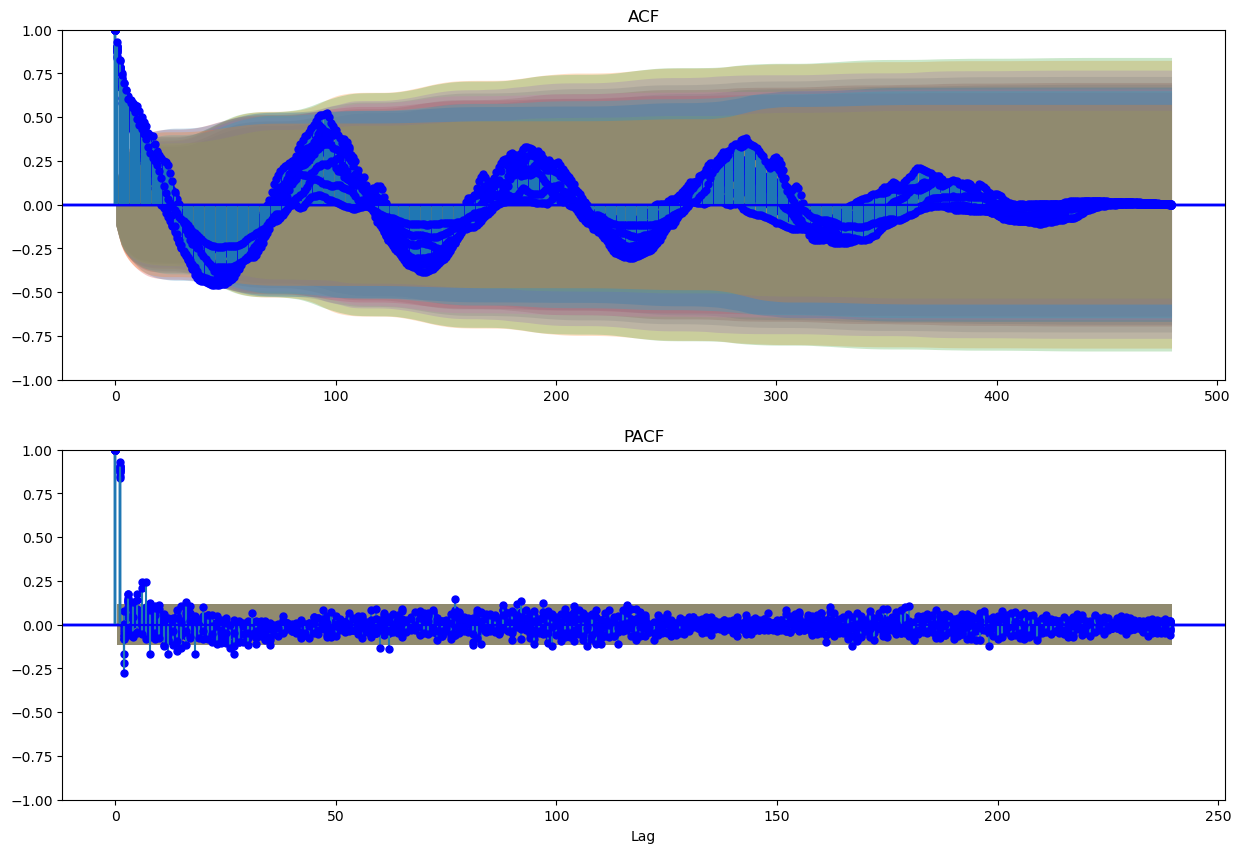

In [66]:
# create function for plotting acf and pacf for all systems in a grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(y):
    """
    Plot the acf and pacf for all systems in a grid
    """
    _, ax = plt.subplots(2, 1, figsize=(15, 10))
    for i in range(y.shape[1]):
        plot_acf(y[:, i], ax=ax[0], alpha=0.01, lags=len(y) - 1, title='ACF', color='b')
        plot_pacf(y[:, i], ax=ax[1], alpha=0.01, lags=len(y) // 2 - 1, title='PACF', color='b', method='ywm')
    
    plt.xlabel('Lag')
    
    plt.show()

plot_acf_pacf(y)
    


# TODO!! Decide how to use ACF / PACF on selecting amount of data to GP Model & Time Series Models

In [ ]:
from statsmodels.tsa.api import AutoReg, ARIMA, SARIMAX, ExponentialSmoothing, MarkovAutoregression


class TimeSeriesForecastingModel:
    """ 
    Global class for time series forecasting models
    
    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, time_train, y_train, time_test, y_test):
        self.time_train = time_train
        self.y_train = y_train
        self.time_test = time_test
        self.y_test = y_test
    
    def exponential_smoothing(self, **kwargs):
        """
        Exponential smoothing model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def arima(self, **kwargs):
        """
        ARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarima(self, **kwargs):
        """
        SARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarimax(self, **kwargs):
        """
        SARIMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def var(self, **kwargs):
        """
        VAR model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def varmax(self, **kwargs):
        """
        VARMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    
    